In [1]:
import pandas
import datetime
import numpy
from davitpy.models import *
from davitpy import utils
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from scipy import signal, ndimage
%matplotlib inline

In [2]:
selDT = datetime.datetime( 2012, 6, 18, 2, 45 )

In [3]:
inpTecFile = "../data/gps120618g.001.hdf5"
dataDF = pandas.read_hdf(inpTecFile, 'Data/Table Layout')
dataDF["date"] = pandas.to_datetime(dataDF["year"]*10000000000 +\
                                    dataDF["month"]*100000000 + dataDF["day"]*1000000 +\
                                    dataDF["hour"]*10000 + dataDF["min"]*100 +\
                                    dataDF["sec"],format='%Y%m%d%H%M%S')
# Only take selected datetime
dataDF["selTimeDel"] = dataDF["date"] - selDT
dataDF = dataDF[ dataDF["selTimeDel"] == min(abs(dataDF["selTimeDel"])) ].reset_index(drop=True)
# Discard bad tec values
dataDF = dataDF[ dataDF["tec"] <= 50. ]
dataDF.head()

,year,month,day,hour,min,sec,ut1_unix,ut2_unix,recno,gdlat,glon,tec,dtec,date,selTimeDel
0,2012,6,18,2,47,30,1339987500,1339987800,68,-90,149,1.9,2.6,2012-06-18 02:47:30,00:02:30
1,2012,6,18,2,47,30,1339987500,1339987800,68,-90,152,1.9,2.6,2012-06-18 02:47:30,00:02:30
2,2012,6,18,2,47,30,1339987500,1339987800,68,-90,155,1.4,2.6,2012-06-18 02:47:30,00:02:30
3,2012,6,18,2,47,30,1339987500,1339987800,68,-90,157,1.1,2.6,2012-06-18 02:47:30,00:02:30
4,2012,6,18,2,47,30,1339987500,1339987800,68,-90,159,1.0,2.6,2012-06-18 02:47:30,00:02:30


In [4]:
gLonArr = dataDF["glon"].values
gdLatArr = dataDF["gdlat"].values
currDT = datetime.datetime.utcfromtimestamp(dataDF["date"].values[0].tolist()/1e9)

mlon, mlat = utils.coord_conv( gLonArr, gdLatArr, \
                                 "geo", "mag", altitude=300., \
                                 date_time=currDT )
dataDF["mlon"] = mlon
dataDF["mlat"] = mlat
dataDF["mlt"] = [ aacgm.mltFromYmdhms(currDT.year, \
                currDT.month,currDT.day, currDT.hour,\
                currDT.minute, currDT.second, x) for x in dataDF["mlon"] ]
dataDF["normMLT"] = [x-24 if x >= 12\
             else x for x in dataDF['mlt']]
dataDF.head()

,year,month,day,hour,min,sec,ut1_unix,ut2_unix,recno,gdlat,glon,tec,dtec,date,selTimeDel,mlon,mlat,mlt,normMLT
0,2012,6,18,2,47,30,1339987500,1339987800,68,-90,149,1.9,2.6,2012-06-18 02:47:30,00:02:30,18.472788,-74.917784,23.170929,-0.829071
1,2012,6,18,2,47,30,1339987500,1339987800,68,-90,152,1.9,2.6,2012-06-18 02:47:30,00:02:30,18.472788,-74.917784,23.170929,-0.829071
2,2012,6,18,2,47,30,1339987500,1339987800,68,-90,155,1.4,2.6,2012-06-18 02:47:30,00:02:30,18.472788,-74.917784,23.170929,-0.829071
3,2012,6,18,2,47,30,1339987500,1339987800,68,-90,157,1.1,2.6,2012-06-18 02:47:30,00:02:30,18.472788,-74.917784,23.170929,-0.829071
4,2012,6,18,2,47,30,1339987500,1339987800,68,-90,159,1.0,2.6,2012-06-18 02:47:30,00:02:30,18.472788,-74.917784,23.170929,-0.829071


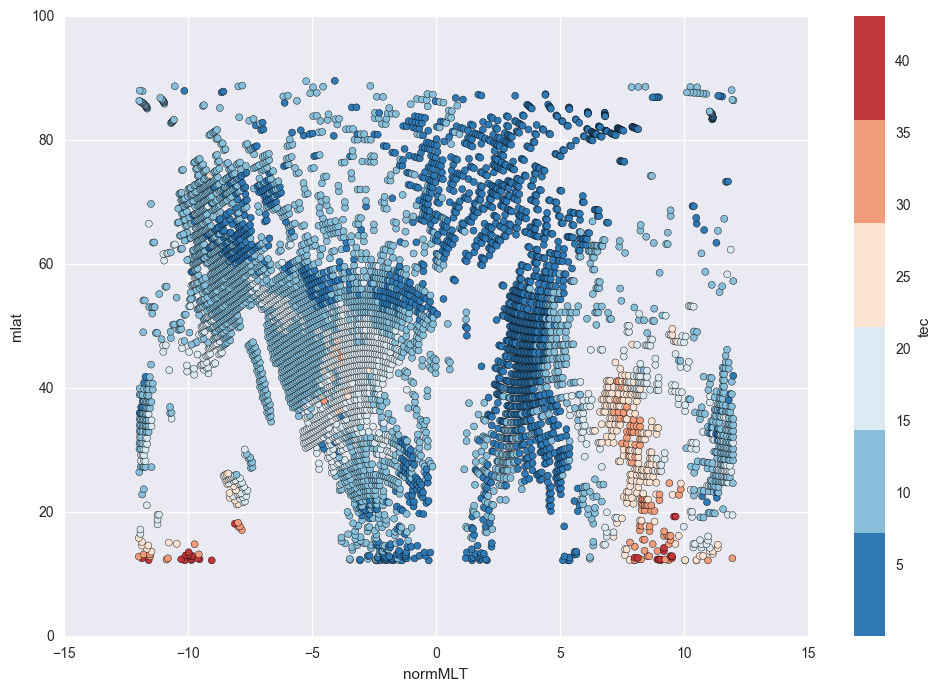

In [5]:
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)
seaMap = ListedColormap(sns.color_palette("RdBu_r"))
dataDF[dataDF["mlat"] > 0.].plot( kind='scatter',
              x='normMLT',
              y='mlat',
              c='tec',
              s=25, cmap=seaMap, ax=ax)

In [6]:
test1 = dataDF[ ["gdlat", "glon", "tec"] ].as_matrix()
test2 = signal.medfilt( test1, kernel_size=(3,1) )
test3 = ndimage.median_filter( test1, 1 )

In [7]:
print test1

[[ -90.   149.     1.9]
 [ -90.   152.     1.9]
 [ -90.   155.     1.4]
 ..., 
 [  87.    39.     4.1]
 [  87.    41.     4.1]
 [  87.    43.     4.2]]


In [8]:
print test2#-test1

[[ -90.   149.     1.9]
 [ -90.   152.     1.9]
 [ -90.   155.     1.4]
 ..., 
 [  87.    39.     4.1]
 [  87.    41.     4.1]
 [  87.    41.     4.1]]
